In [1]:
# I noticed on some of Ian's images that the lattice wasn't being completely masked.
# I suspect the reason is the search is missing those points because we aren't extending the grid to cover
# The whole image.

# OR

# The problem could be that I am not completely masking a point.

In [2]:
# I need a way to look at the power spectrum of an image after subtraction. Let's pick an example and take
# it to that point.

# Copy/paste some parameters from mask_pbsapo_micrographs.ipynb

In [4]:
import saxtal_functions as sax
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import os
from funcs_mrcio import iwrhdr_opened, irdhdr_opened, iwrsec_opened, irdsec_opened
from itertools import product

In [9]:
threshold_method='sd' 
pixel_size = 1.048
verbose=True
show_plots=True
threads=16
sigma=9
num_sd=4
num_sd_secondpass=2
x_window_percent=(0.01, 0.95)
y_window_percent=(0, 1)
miller_index_buffer=10
box_radius=10
min_lattice_size=8
epsilon=0.25
mask_hotpixels=False
mask_radius=5
replace_angle=10
return_spots=False
return_stats=False
return_image=False

filename = 'test_data/test_lattice.mrc'
filename_out = 'test_data/test_lattice_masked.mrc'

scipy_fft(): FFT performed in 152.84 milliseconds.
0 29 5760 2737
[-1.1127068e-05] [0.18990539]
Number of first-pass spots found: 539


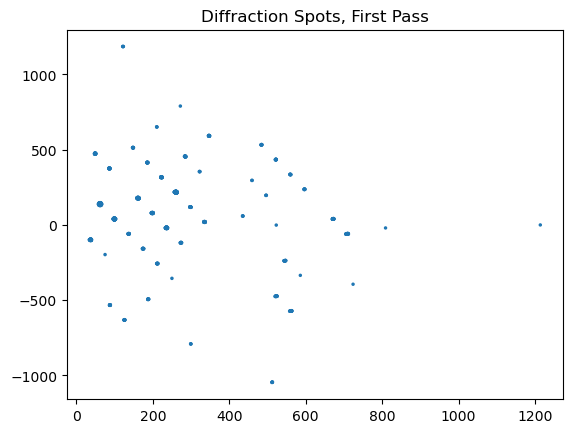

Starting basis: [[139  40]
 [ 62  99]]
Starting basis size: 34566
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 43.96036738400097
[139  62] is larger than [40 99]
The updated basis vectors are [ 99 -37][40 99]
This run resulted in a basis smaller than the last: 22571
The updated basis vectors are: [[-99  40]
 [ 37  99]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.50810358067031
[40 99] is larger than [-99  37]
The updated basis vectors are [-59 136][-99  37]
This run resulted in a basis larger than the last: 33147
Terminating loop.
------------------------------------


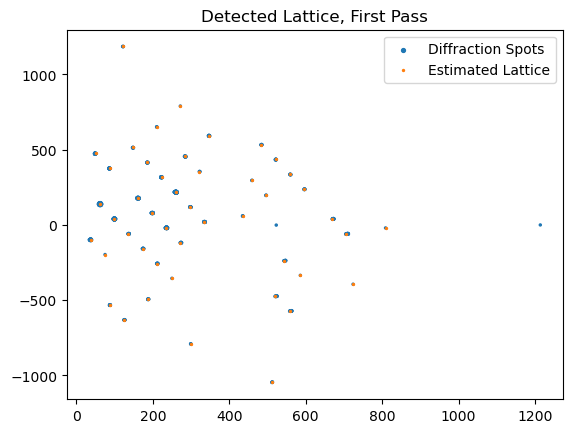

Starting basis: [[-99  40]
 [ 37  99]]
Refined_basis: [[-98.85455011  39.62033611]
 [ 37.36594983  99.28073302]]
Unit cell dimensions (A): 57.12 56.47
Highest resolution spot (A): 5.06


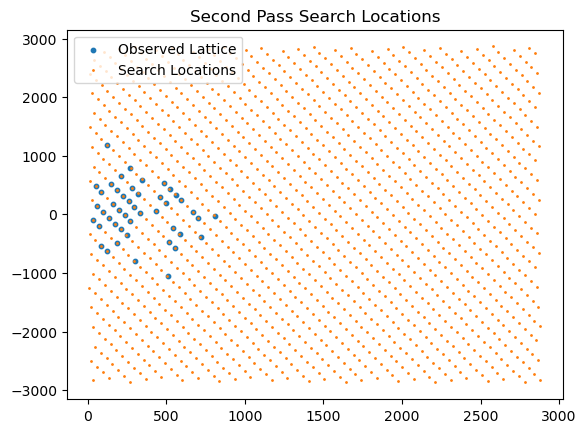

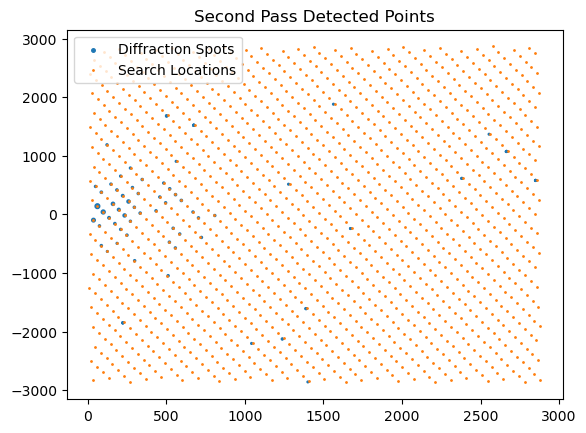

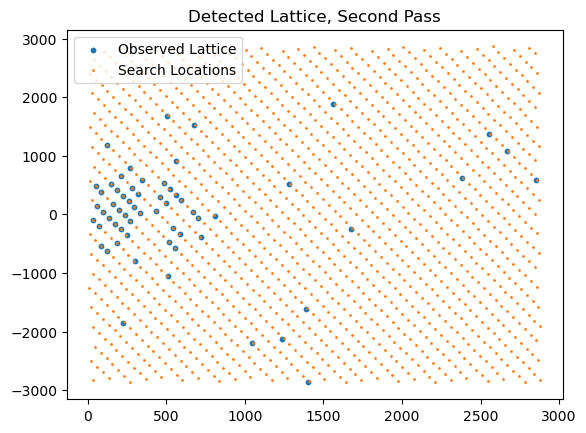

Highest resolution spot from second pass (A): 1.9
[[1674  498]
 [1674  499]
 [1674  500]
 ...
 [2905 1404]
 [2905 1405]
 [2905 1406]]
unwrap
[[ 1674   498]
 [ 1674   499]
 [ 1674   500]
 ...
 [-2855  1404]
 [-2855  1405]
 [-2855  1406]]
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1682
hi
1682
hi
1682
hi
1682
hi
1682
hi
1682
hi
1682
hi
168

hi
57
hi
57
hi
57
hi
58
hi
58
hi
58
hi
58
hi
58
hi
58
hi
58
hi
58
hi
58
hi
58
hi
58
hi
59
hi
59
hi
59
hi
59
hi
59
hi
59
hi
59
hi
59
hi
59
hi
59
hi
59
hi
60
hi
60
hi
60
hi
60
hi
60
hi
60
hi
60
hi
60
hi
60
hi
60
hi
60
hi
61
hi
61
hi
61
hi
61
hi
61
hi
61
hi
61
hi
61
hi
61
hi
61
hi
61
hi
62
hi
62
hi
62
hi
62
hi
62
hi
62
hi
62
hi
62
hi
62
hi
62
hi
62
hi
63
hi
63
hi
63
hi
63
hi
63
hi
63
hi
63
hi
63
hi
63
hi
63
hi
63
hi
64
hi
64
hi
64
hi
64
hi
64
hi
64
hi
64
hi
64
hi
64
hi
64
hi
64
hi
65
hi
65
hi
65
hi
65
hi
65
hi
65
hi
65
hi
65
hi
65
hi
65
hi
65
hi
-202
not hi
-202
not hi
-202
not hi
-202
not hi
-202
not hi
-202
not hi
-202
not hi
-202
not hi
-202
not hi
-202
not hi
-202
not hi
-201
not hi
-201
not hi
-201
not hi
-201
not hi
-201
not hi
-201
not hi
-201
not hi
-201
not hi
-201
not hi
-201
not hi
-201
not hi
-200
not hi
-200
not hi
-200
not hi
-200
not hi
-200
not hi
-200
not hi
-200
not hi
-200
not hi
-200
not hi
-200
not hi
-200
not hi
-199
not hi
-199
not hi
-199
not hi
-199
not hi
-199
no

0 29 5760 2737
[-1.20507975e-05] [0.18974186]


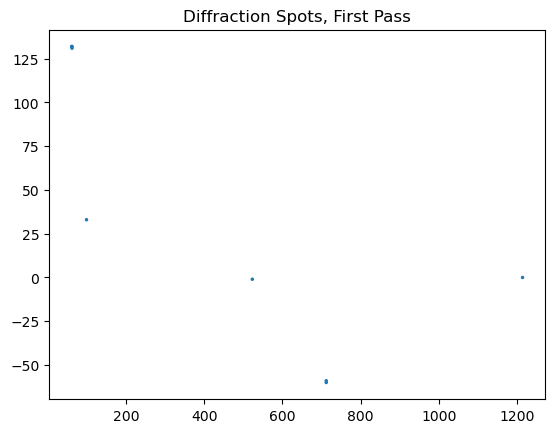

Lattice has less than 8 candidate basis vectors during first pass. Terminating function.


In [10]:
masked_fft = sax.mask_image(filename,
               filename_out,
               threshold_method = threshold_method,
               pixel_size = pixel_size,
               verbose = verbose,
               show_plots = show_plots,
               threads = threads,
               sigma = sigma,
               num_sd = num_sd,
               num_sd_secondpass = num_sd_secondpass,
               x_window_percent = x_window_percent,
               y_window_percent = y_window_percent,
               miller_index_buffer = miller_index_buffer,
               box_radius = box_radius,
               min_lattice_size = min_lattice_size,
               mask_radius= mask_radius,
               replace_angle = replace_angle,
               epsilon = epsilon,
               return_spots = False,
               return_stats = False,
               return_fft = True,
               return_image = False)

In [ ]:
# Import the image
image, header = sax.import_mrc(filename)

# Perform an FFT of the image
padded_fft = sax.scipy_fft(image, verbose, threads)

# Subtract the FFT from a Gaussian-smoothed FFT
log_diff_spectrum, smoothed_spectrum = sax.generate_diff_spectrum(padded_fft, sigma)

# Find diffraction spots
if threshold_method == "quantile":
    diffraction_indices, diffraction_amplitudes = sax.find_diffraction_spots_quantile(log_diff_spectrum, quantile, x_window_percent, y_window_percent)
if threshold_method == "sd":
    diffraction_indices, diffraction_amplitudes = sax.find_diffraction_spots_sd(log_diff_spectrum, num_sd, x_window_percent, y_window_percent)

# Return some info if function is verbose
if verbose:
    print("Number of first-pass spots found: " + str(diffraction_indices.shape[1]))

In [9]:
diffraction_indices[0]

array([ 591,  591,  592,  592,  592,  593,  593,  620,  621,  739,  761,
        850,  851,  923,  957,  960, 1015, 1054, 1055, 1090, 1134, 1149,
       1150, 1199, 1200, 1211, 1212, 1226, 1231, 1238, 1273, 1293, 1294,
       1299, 1313, 1314, 1328, 1329, 1330, 1343, 1344, 1378, 1379, 1380,
       1399, 1406, 1407, 1408, 1409, 1410, 1434, 1435, 1439, 1440, 1461,
       1471, 1472, 1506, 1507, 1537, 1548, 1549, 1562, 1563, 1577, 1578,
       1583, 1596, 1597, 1637, 1681, 1685, 1686, 1686, 1701, 1710, 1720,
       1733, 1738, 1779, 1780, 1781, 1789, 1790, 1839, 1840, 1840, 1841,
       1842, 1862, 1890, 1915, 1916, 1930, 1931, 1931, 1932, 1948, 1992,
       2012, 2013, 2030, 2031, 2032, 2033, 2039, 2040, 2058, 2059, 2121,
       2122, 2127, 2141, 2172, 2173, 2194, 2195, 2217, 2231, 2232, 2249,
       2250, 2251, 2286, 2287, 2288, 2291, 2309, 2310, 2355, 2398, 2399,
       2399, 2400, 2400, 2401, 2421, 2422, 2422, 2423, 2423, 2424, 2425,
       2498, 2499, 2511, 2512, 2513, 2514, 2537, 25

<Figure size 6000x6000 with 0 Axes>

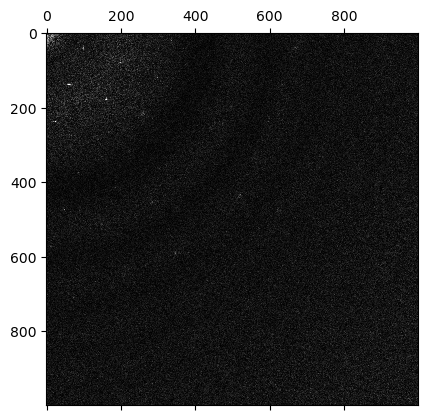

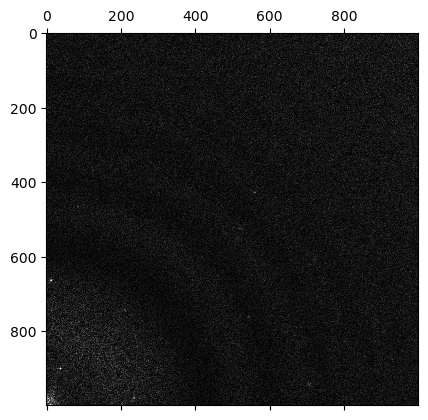

In [29]:
from matplotlib.pyplot import figure
figure(figsize=(20, 20), dpi=300)
# Display the unmasked power spectrum



plt.matshow(np.abs(padded_fft)[0:1000, 0:1000],
           cmap = "Greys_r",
           vmax = 7000,
           vmin = 0)

plt.matshow(np.abs(padded_fft)[-1000:, :1000],
           cmap = "Greys_r",
           vmax = 7000,
           vmin = 0)

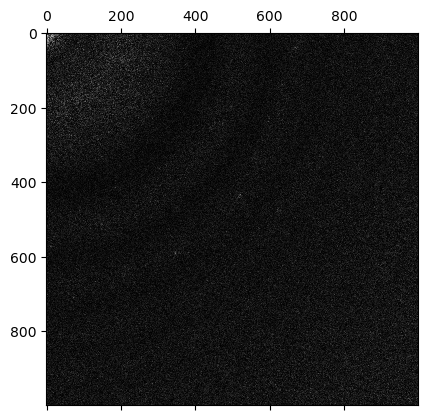

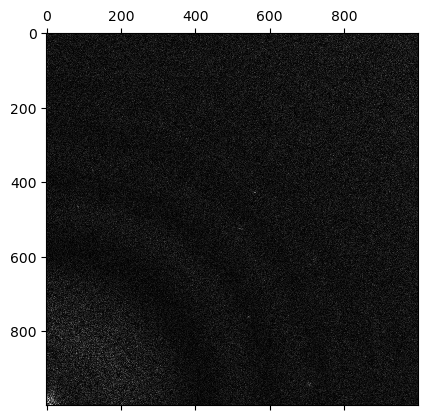

In [28]:
# Display the masked power spectrum

plt.matshow(np.abs(masked_fft)[:1000, :1000],
           cmap = "Greys_r",
           vmax = 7000,
           vmin = 0)

plt.matshow(np.abs(masked_fft)[-1000:, :1000],
           cmap = "Greys_r",
           vmax = 7000,
           vmin = 0)

scipy_fft(): FFT performed in 155.85 milliseconds.
0 29 5760 2737
[-1.1127068e-05] [0.18990539]
Number of first-pass spots found: 539


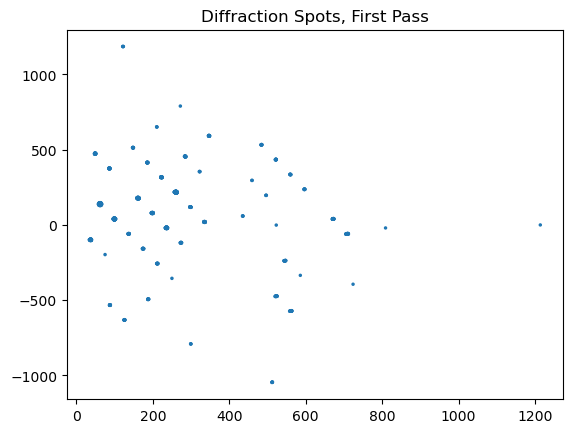

Starting basis: [[139  40]
 [ 62  99]]
Starting basis size: 34566
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 43.96036738400097
[139  62] is larger than [40 99]
The updated basis vectors are [ 99 -37][40 99]
This run resulted in a basis smaller than the last: 22571
The updated basis vectors are: [[-99  40]
 [ 37  99]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.50810358067031
[40 99] is larger than [-99  37]
The updated basis vectors are [-59 136][-99  37]
This run resulted in a basis larger than the last: 33147
Terminating loop.
------------------------------------


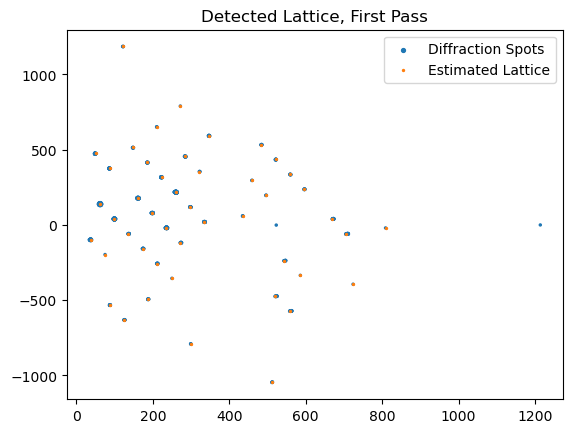

Starting basis: [[-99  40]
 [ 37  99]]
Refined_basis: [[-98.85455011  39.62033611]
 [ 37.36594983  99.28073302]]
Unit cell dimensions (A): 57.12 56.47
Highest resolution spot (A): 5.06


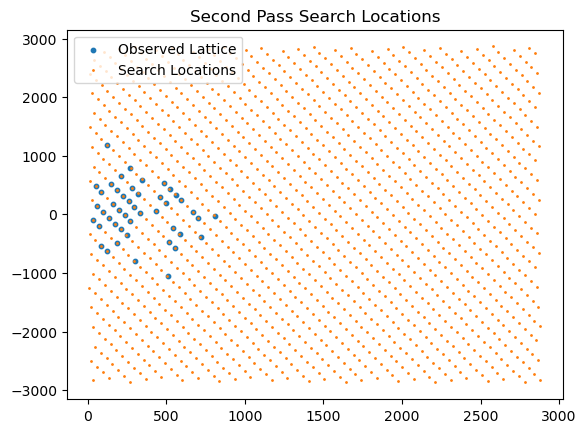

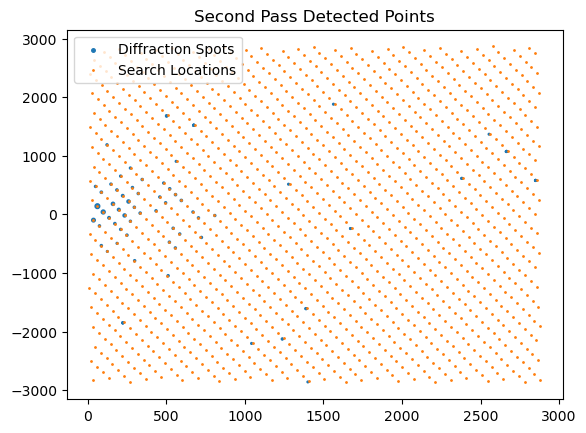

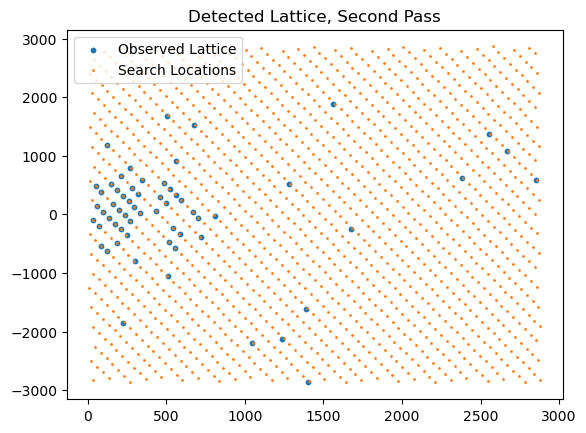

Highest resolution spot from second pass (A): 1.9
[[1674  498]
 [1674  499]
 [1674  500]
 ...
 [2905 1404]
 [2905 1405]
 [2905 1406]]
unwrap
[[ 1674   498]
 [ 1674   499]
 [ 1674   500]
 ...
 [-2855  1404]
 [-2855  1405]
 [-2855  1406]]
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1674
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1675
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1676
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1677
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1678
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1679
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1680
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1681
hi
1682
hi
1682
hi
1682
hi
1682
hi
1682
hi
1682
hi
1682
hi
168

hi
241
hi
241
hi
241
hi
241
hi
241
hi
241
hi
241
hi
242
hi
242
hi
242
hi
242
hi
242
hi
242
hi
242
hi
242
hi
242
hi
242
hi
242
hi
509
hi
509
hi
509
hi
509
hi
509
hi
509
hi
509
hi
509
hi
509
hi
509
hi
509
hi
510
hi
510
hi
510
hi
510
hi
510
hi
510
hi
510
hi
510
hi
510
hi
510
hi
510
hi
511
hi
511
hi
511
hi
511
hi
511
hi
511
hi
511
hi
511
hi
511
hi
511
hi
511
hi
512
hi
512
hi
512
hi
512
hi
512
hi
512
hi
512
hi
512
hi
512
hi
512
hi
512
hi
513
hi
513
hi
513
hi
513
hi
513
hi
513
hi
513
hi
513
hi
513
hi
513
hi
513
hi
514
hi
514
hi
514
hi
514
hi
514
hi
514
hi
514
hi
514
hi
514
hi
514
hi
514
hi
515
hi
515
hi
515
hi
515
hi
515
hi
515
hi
515
hi
515
hi
515
hi
515
hi
515
hi
516
hi
516
hi
516
hi
516
hi
516
hi
516
hi
516
hi
516
hi
516
hi
516
hi
516
hi
517
hi
517
hi
517
hi
517
hi
517
hi
517
hi
517
hi
517
hi
517
hi
517
hi
517
hi
518
hi
518
hi
518
hi
518
hi
518
hi
518
hi
518
hi
518
hi
518
hi
518
hi
518
hi
519
hi
519
hi
519
hi
519
hi
519
hi
519
hi
519
hi
519
hi
519
hi
519
hi
519
hi
1069
hi
1069
hi
1069
hi


0 29 5760 2737
[-1.20507975e-05] [0.18974186]


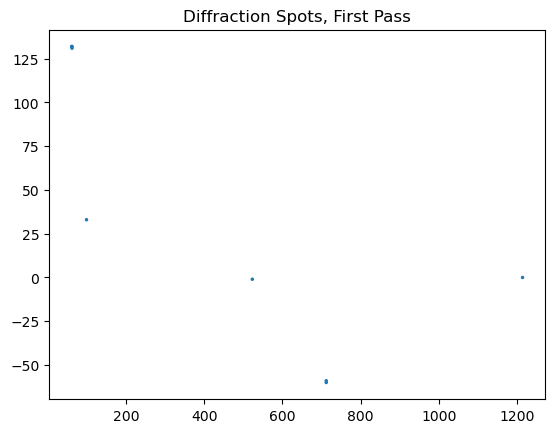

Lattice has less than 8 candidate basis vectors during first pass. Terminating function.
scipy_ifft(): iFFT performed in 134.67 milliseconds.
Export complete!
test_data/test_lattice.mrc masked successfully!


In [11]:
sax.mask_image(filename,
               filename_out,
               threshold_method = threshold_method,
               pixel_size = pixel_size,
               verbose = verbose,
               show_plots = show_plots,
               threads = threads,
               sigma = sigma,
               num_sd = num_sd,
               num_sd_secondpass = num_sd_secondpass,
               x_window_percent = x_window_percent,
               y_window_percent = y_window_percent,
               miller_index_buffer = miller_index_buffer,
               box_radius = box_radius,
               min_lattice_size = min_lattice_size,
               mask_radius= mask_radius,
               replace_angle = replace_angle,
               epsilon = epsilon,
               return_spots = False,
               return_stats = False,
               return_fft = False,
               return_image = False)